<a href="https://colab.research.google.com/github/S-Gilson/RelEns/blob/main/AML4DS2024_Julius_and_Sebastian_ogbl_biokg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Introduction
This is the code for Julius and Sebastian's mini-project for AML4DS2024. The presentation can be found [here](https://docs.google.com/presentation/d/1Xw1sKKe3qXG26of2zVgMLBXaFcX-zkS6eJjDuFATK44/edit?usp=sharing).

Our mini-project is based on one of OGB's benchmark Knowledge Graphs (KG), specificlaly the Biomedical Knowledge Graph (ogbl-biokg). Information about the KG can be found [here](https://ogb.stanford.edu/docs/linkprop/#ogbl-biokg).

We use the ComplEx model as our baseline model, first introduced by Trouillon et al. in [*Complex Embeddings for Simple Link Prediction*](https://arxiv.org/pdf/1606.06357) in 2016.

The implementation of the ComplEx model is inspired by the [following project](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/kge_fb15k_237.py), which is an implementation of ComplEx on FB15K_237. As you can see below, we have imported the ComplEx model via the [pytorch module](https://github.com/pyg-team/pytorch_geometric/blob/2947af7733d87315a9218a0bfabbfda10b595f0e/torch_geometric/nn/kge/complex.py).


The networkx and data visualisation code in this notebook is based on [the following](https://colab.research.google.com/drive/1n1edsDTR3s2T3OSi6EiIf0rHzHKSES_R?usp=sharing#scrollTo=XlzbhoxhGMXz) from Hasso Plattner Institute's (HPI) course on KGs.


### Dependencies

In [3]:
!pip install -q ogb
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.0 MB/s eta 0:00:00


In [4]:
from ogb.linkproppred import LinkPropPredDataset
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import torch
import torch.optim as optim
from torch_geometric.nn import ComplEx, GCNConv
from tqdm import tqdm

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
!nvidia-smi

cpu
/bin/bash: line 1: nvidia-smi: command not found


### Dataset

In [ ]:
# Google Colab path to dataset
root = '/content/gdrive/MyDrive/OGB_Folder'

# Loading the dataset
dataset = LinkPropPredDataset(name = "ogbl-biokg", root=root)

graph = dataset[0]
print(graph.keys())
print("Dictionary of number of nodes under each entity in the dataset: ", graph['num_nodes_dict'])

dict_keys(['edge_index_dict', 'edge_feat_dict', 'node_feat_dict', 'num_nodes_dict', 'edge_reltype'])
Dictionary of number of nodes under each entity in the dataset:  {'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}


In [ ]:
train_set_path = '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/split/random/train.pt'
test_set_path = '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/split/random/test.pt'
valid_set_path = '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/split/random/valid.pt'

# Loading the train dataset
train_set = torch.load(train_set_path)
test_set = torch.load(test_set_path)
valid_set = torch.load(valid_set_path)

In [ ]:
print(train_set.keys())

dict_keys(['head_type', 'head', 'relation', 'tail_type', 'tail'])


In [ ]:
# First five item/triples in the train_set
for key in train_set.keys():
    if isinstance(train_set[key], list) or isinstance(train_set[key], np.ndarray):
        print(f"{key}: {train_set[key][:5]}")

head_type: ['disease', 'disease', 'disease', 'disease', 'disease']
head: [ 1718  4903  5480  3148 10300]
relation: [0 0 0 0 0]
tail_type: ['protein', 'protein', 'protein', 'protein', 'protein']
tail: [ 3207 13662 15999  7247 16202]



Note that 'relation' being '0' does not mean there is no relation - 0 is the ID of the 'disease-protein' relation.



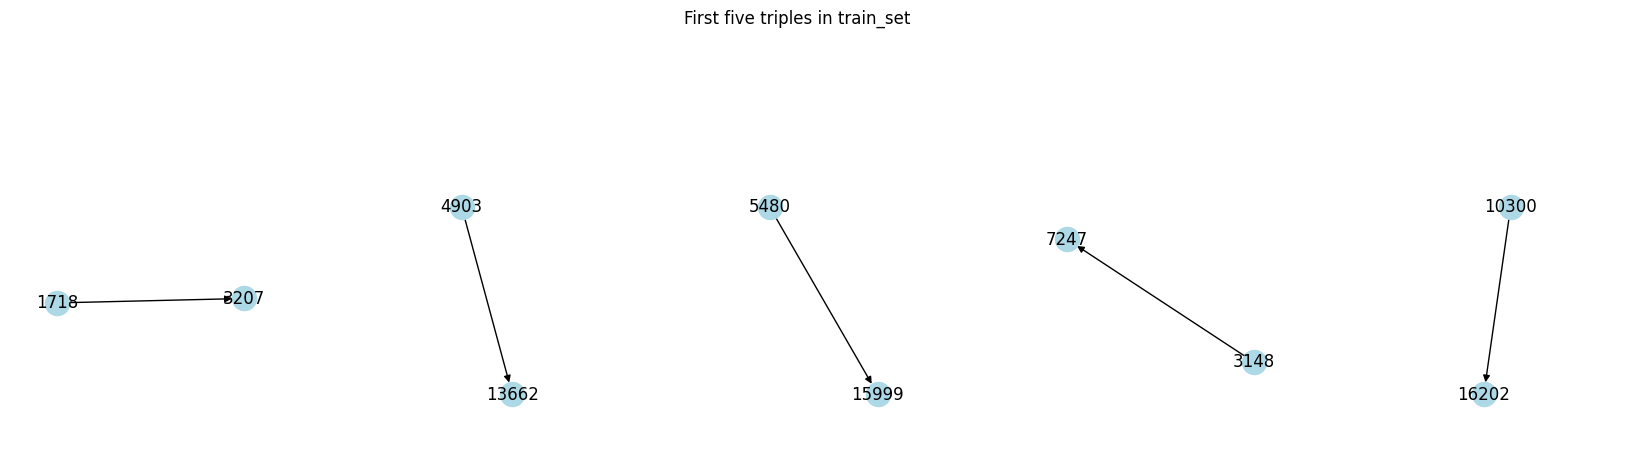

In [ ]:
# @title First five triples in train_set visualised
def plot_graph(data, num_triples=5):
    fig, axs = plt.subplots(1, num_triples, figsize=(21, 6))
    fig.suptitle('First five triples in train_set')

    # Add the first num_triples triples into the graph
    for i in range(num_triples):
        # Create a new directed graph
        G = nx.DiGraph()

        head_type = data['head_type'][i]
        head = data['head'][i]
        relation = data['relation'][i]
        tail_type = data['tail_type'][i]
        tail = data['tail'][i]

        # each edge is labeled with the relation
        G.add_edge(head, tail, label=relation)

        # Use spring layout to spread out the nodes
        pos = nx.spring_layout(G)

        # Draw the graph
        nx.draw(G, pos, with_labels=True, node_color='lightblue', ax=axs[i])

        # Box in the subplot
        axs[i].set_box_aspect(1)
        axs[i].set_xlim([-1.5, 1.5])
        axs[i].set_ylim([-1.5, 1.5])

        # Set the visibility of the box
        for spine in axs[i].spines.values():
            spine.set_visible(True)

    plt.show()

# Apply the function to the train_set
plot_graph(train_set)


In [ ]:
# First five items/triples in the test_set - note that the negatives turns it into a 2-dimensional array
for key in test_set.keys():
    value = test_set[key]
    if isinstance(value, list) or isinstance(value, np.ndarray):
        print(f"{key}: {value[:5]}")  # adjust the number as needed
    else:
        print(f"{key}: {value}")


head_type: ['disease', 'disease', 'disease', 'disease', 'disease']
head: [1429 9419  829  170 4677]
head_neg: [[  733  7110  8687 ...  2971  2020  4890]
 [ 5460  4316 10332 ...  8677  2024  2321]
 [ 4085  9310  9537 ...  2887  9712  6667]
 [ 3597  2619   910 ...  7882  3384  1865]
 [ 6170  5880  3868 ...  7028  7244  3232]]
relation: [0 0 0 0 0]
tail_type: ['protein', 'protein', 'protein', 'protein', 'protein']
tail: [10178 14320  8662  5020 13550]
tail_neg: [[13523  5150  9448 ...  5313  6520   755]
 [ 8929 16549 15866 ... 11901  3427  5040]
 [ 6087   113 10905 ...  2057  7327  3016]
 [ 4952  8535 11105 ...  5772  6612  3273]
 [ 7516  8824 16958 ... 15000  5258 15198]]


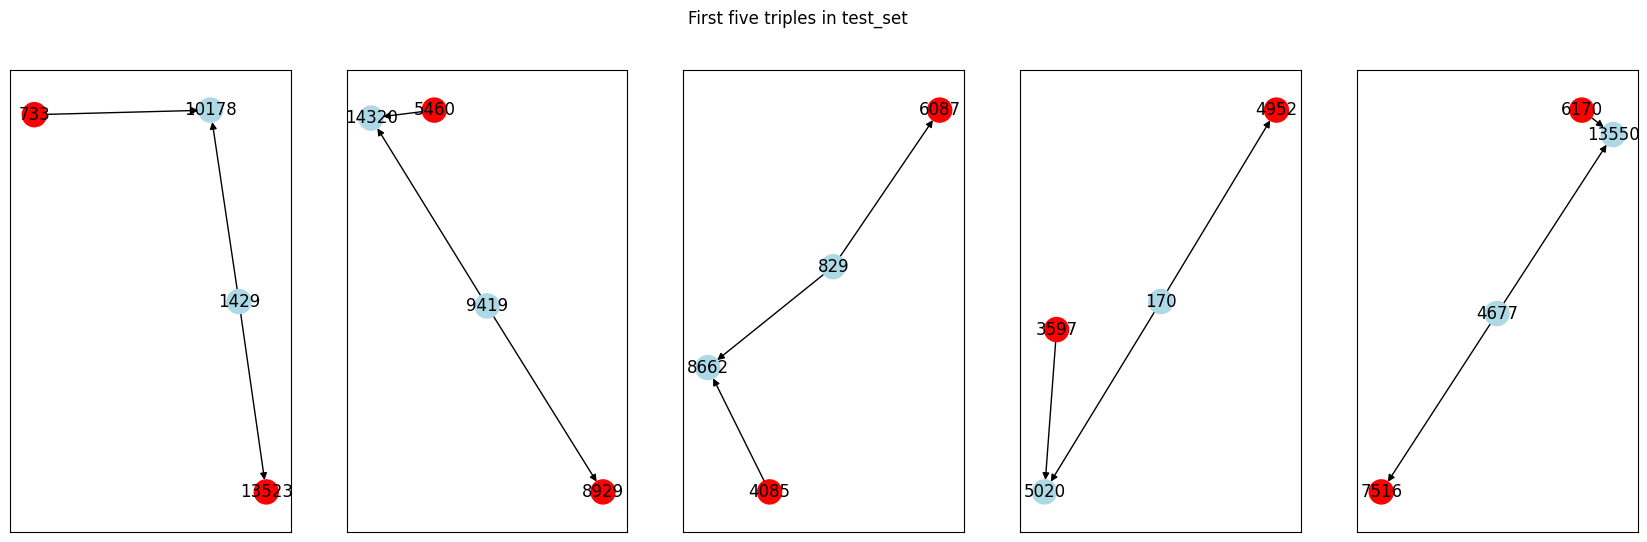

In [ ]:
# @title First five triples from test_set with negative head and tail examples highlighted in red
def plot_data(data, num_triples=5):
    fig, axs = plt.subplots(1, num_triples, figsize=(21, 6))
    fig.suptitle('First five triples in test_set')

    # Add the first num_triples triples into the graph
    for i in range(num_triples):
        # Create a new directed graph
        G = nx.DiGraph()

        head_type = data['head_type'][i]
        head = data['head'][i]
        relation = data['relation'][i]
        tail_type = data['tail_type'][i]
        tail = data['tail'][i]

        # each edge is labeled with the relation
        G.add_edge(head, tail, label=relation)

        # Add one negative head and one negative tail as red nodes
        neg_head = data['head_neg'][i][0]
        G.add_node(neg_head, color='red')
        G.add_edge(neg_head, tail, label='neg_relation')

        neg_tail = data['tail_neg'][i][0]
        G.add_node(neg_tail, color='red')
        G.add_edge(head, neg_tail, label='neg_relation')

        # Use spring layout to spread out the nodes
        pos = nx.spring_layout(G)

        # Draw the graph
        nx.draw_networkx_edges(G, pos, ax=axs[i])
        nx.draw_networkx_labels(G, pos, ax=axs[i])
        nx.draw_networkx_nodes(G, pos, node_color=[data.get('color', 'lightblue') for node, data in G.nodes(data=True)], ax=axs[i])

    plt.show()

# Apply the function to the test_set
plot_data(test_set)

In [ ]:
# First five items/triples in the valid_set

for key in valid_set.keys():
    value = valid_set[key]
    if isinstance(value, list) or isinstance(value, np.ndarray):
        print(f"{key}: {value[:5]}")  # adjust the number as needed
    else:
        print(f"{key}: {value}")

head_type: ['disease', 'disease', 'disease', 'disease', 'disease']
head: [3935  287 1094  495 4794]
head_neg: [[ 3851  3068  1491 ...  2037  2439  3054]
 [ 5450  8003  5639 ...   591  7041  6457]
 [ 7967   511 10340 ...  1435  8675   855]
 [ 7824  7715  9241 ...  1017  6573  4944]
 [ 4050 10509  1316 ...  1965   317  6017]]
relation: [0 0 0 0 0]
tail_type: ['protein', 'protein', 'protein', 'protein', 'protein']
tail: [ 1987   530 17013  1521 13055]
tail_neg: [[ 2143  7551 14670 ...  1992  1301 11845]
 [ 1497  3374  5463 ...  1915 12673  9105]
 [ 6621  7033 12053 ... 14110  7381 13653]
 [13612 10499 11981 ... 13037 16606 15828]
 [ 1110 14995 10961 ... 11054  4400  9870]]


The total number of edges (train_set, valid_set and test_set) amounts to 5,088,434.

In [ ]:
paths = {
    'disease': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/disease_entidx2name.csv.gz',
    'drug': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/drug_entidx2name.csv.gz',
    'function': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/function_entidx2name.csv.gz',
    'sideeffect': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/sideeffect_entidx2name.csv.gz',
    'protein': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/protein_entidx2name.csv.gz',
    'relation': '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/relidx2relname.csv.gz'
}

In [ ]:
# Define the path to your protein mapping file
protein_mapping_path = '/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/protein_entidx2name.csv.gz'

# Load the mapping file into a DataFrame
protein_mapping_df = pd.read_csv(protein_mapping_path, index_col=0)

# Convert the DataFrame to a dictionary
protein_mapping = protein_mapping_df['ent name'].to_dict()

# Get the original label for protein 1718
original_label = protein_mapping.get(1718)  # Use integer 1718

if original_label is not None:
    print(f'The original label of protein 1718 is: {original_label}')
else:
    print("The ID 1718 is not found in the protein mapping.")


The original label of protein 1718 is: 117285


Based on genenames.org, gene id 117285 is
'defensin beta 118' - which is a gene that allows protein to encode anti-bacterial properties.

## Visualisation

Visualising the entire knowledge graph is computationally expensive and includes so many nodes and labels that it is not possible to derive any meaning out of it. Instead, we will visualise a sub-graph to showcase the graph structure.

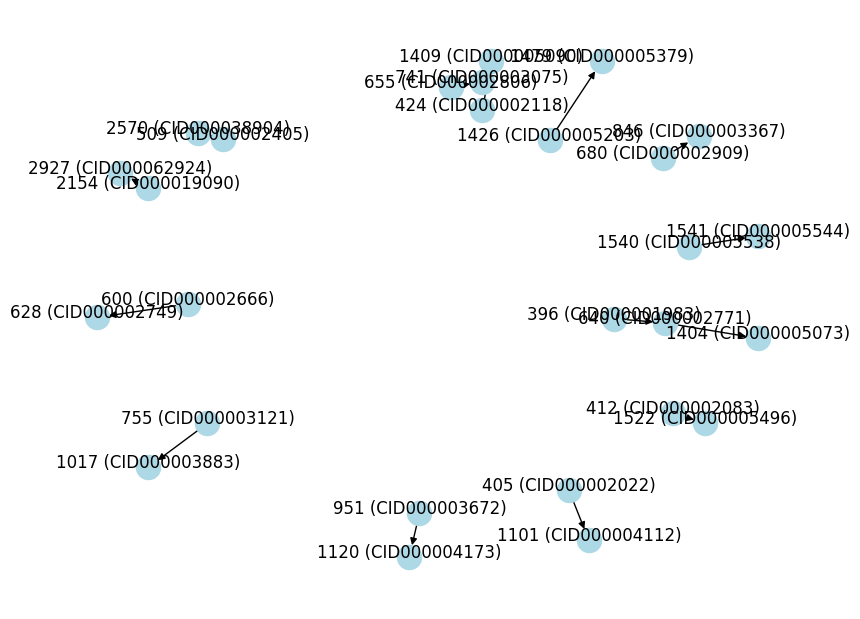

In [ ]:
# @title Below is a visualisation of drug-drug triplets
# Load the .csv.gz file into a pandas DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/drug_entidx2name.csv.gz', compression='gzip')

# Create a dictionary to map node ids to entity types
node_to_entity = df.set_index('ent idx')['ent name'].to_dict()

# Modify the loop where you add edges to also add node attributes
# Only add one edge (two nodes)
source, target = edge_list[:, 0]
G.add_edge(source.item(), target.item())
G.nodes[source.item()]['entity_type'] = node_to_entity.get(source.item(), 'Unknown')
G.nodes[target.item()]['entity_type'] = node_to_entity.get(target.item(), 'Unknown')

# Modify the drawing code to include labels with entity types
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
labels = {node: f'{node} ({data.get("entity_type", "Unknown")})' for node, data in G.nodes(data=True)}

# Draw the nodes
nx.draw(G, pos, node_color='lightblue')

# Draw the node labels
for node, (x, y) in pos.items():
    plt.text(x, y, labels[node], fontsize=12, ha='center')

plt.show()


Wow! A lot is going on.. Let's look at one triplet instead.

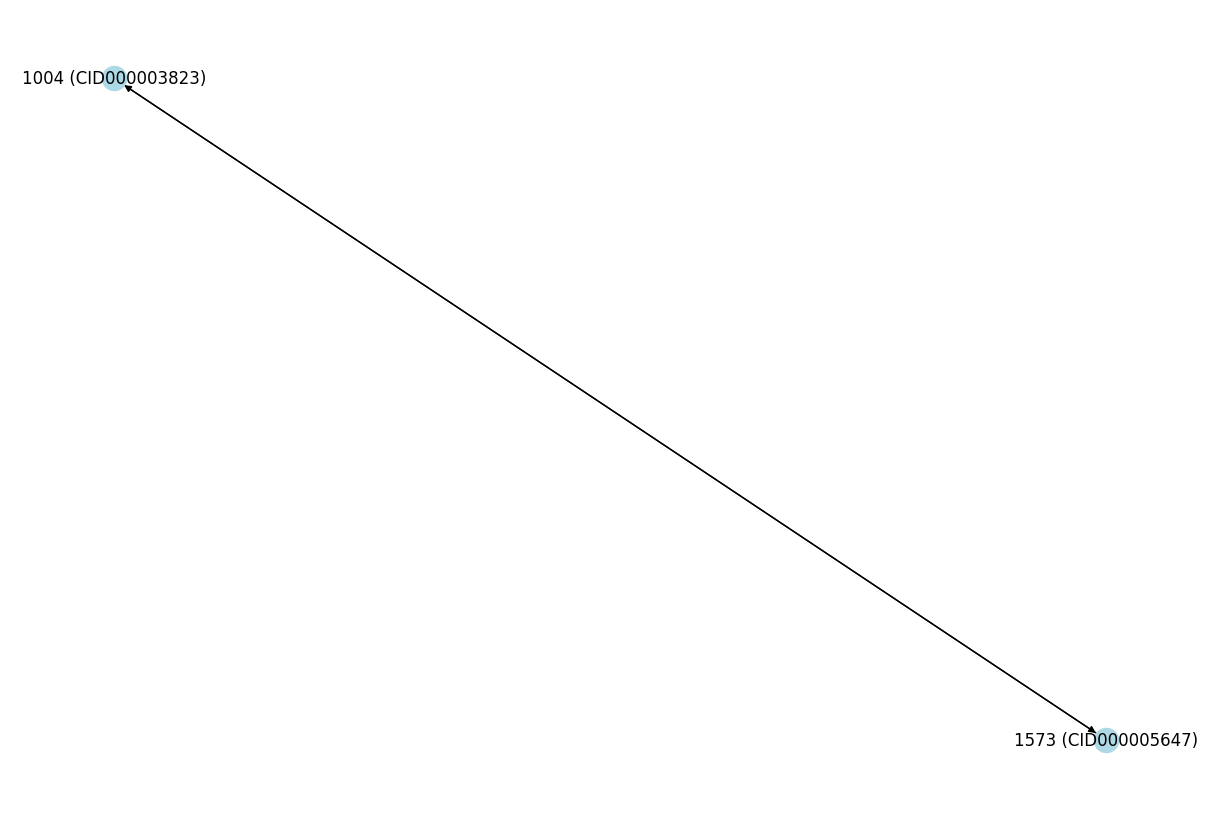

In [ ]:
# @title Let's have a look at a simple example from the dataset

# Load the .csv.gz file into a pandas DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/OGB_Folder/ogbl_biokg/mapping/drug_entidx2name.csv.gz', compression='gzip')

# Create a dictionary to map node ids to entity types
node_to_entity = df.set_index('ent idx')['ent name'].to_dict()

# Create a new directed graph
G = nx.DiGraph()

# Add edges to the graph from your edge_index_dict
edge_index_dict = graph['edge_index_dict']
edge_list = edge_index_dict[('drug', 'drug-drug_sexual_disorder', 'drug')]

# Number of edges to add
num_edges = 1

for i in range(min(num_edges, edge_list.shape[1])):
    source, target = edge_list[:, i]
    G.add_edge(source.item(), target.item())
    G.add_edge(target.item(), source.item())  # relations of the same entity types are symmetric, i.e. we need to add the edge in each direction
    G.nodes[source.item()]['entity_type'] = node_to_entity.get(source.item(), 'Unknown')
    G.nodes[target.item()]['entity_type'] = node_to_entity.get(target.item(), 'Unknown')

# Draw the graph
plt.figure(figsize=(12, 8))

# Use spring layout to spread out the nodes
# Set a fixed seed for the layout algorithm
pos = nx.spring_layout(G, seed=42)

# Create labels with entity types
labels = {node: f'{node} ({data["entity_type"]})' for node, data in G.nodes(data=True)}

# Draw the nodes and labels
nx.draw(G, pos, labels=labels, node_color='lightblue')

plt.show()


###CID000003823 is the drug Ketoconazole - a cream used in the management and treatment of fungal infection.
###CID000005647 is the drug Valtrex - an antiviral drug that treats herpes infections. Intuitively, it makes sense that these drugs have a connection.

## Model 2
Model 2 is our first succesful implementation of the ComplEx model.
Notice the amount of unique nodes, relations and head types in the training data!

In [ ]:
unique_nodes = set(train_set['head']).union(set(train_set['tail']))
num_nodes = len(unique_nodes)
print(f'Number of unique nodes in training data graph: {num_nodes}')

unique_relations = set(train_set['relation'])
num_relations = len(unique_relations)
print(f'Number of unique relations in training data graph: {num_relations}')

Number of unique nodes in training data graph: 45085
Number of unique relations in training data graph: 51


In [ ]:
len(train_set['head_type'])

4762678

The amount of training data affected our ability to train the model - and it was necessary for us to create a subset of the training data to be able to train succesfully. Obviously, this comes with a cost that we will discuss further down.

In [ ]:
small_size = 10000

small_sample=np.random.randint(len(train_set["head"]),size=small_size)

small_train_set = {
    'head': train_set['head'][small_sample],
    'relation': train_set['relation'][small_sample],
    'tail': train_set['tail'][small_sample],
}

unique_nodes = set(small_train_set['head']).union(set(small_train_set['tail']))
rel_types = set(small_train_set['relation'])

small_test_size = int(small_size/5)
small_test_set = {
    'head': [0]*small_test_size,
    'relation': [0]*small_test_size,
    'tail': [0]*small_test_size,
}

index=0
current_test_size=0

while current_test_size < small_test_size:
  if test_set['head'][index] in unique_nodes and test_set['tail'][index] in unique_nodes and test_set['relation'][index] in rel_types:
    small_test_set["head"][current_test_size] = test_set['head'][index]
    small_test_set["relation"][current_test_size] = test_set['relation'][index]
    small_test_set["tail"][current_test_size] = test_set['tail'][index]
    current_test_size+=1
  index+=1

small_valid_size = int(small_size/5)

small_valid_set = {
    'head': [0] * small_valid_size,
    'relation': [0] * small_valid_size,
    'tail': [0] * small_valid_size,
}

index=0
current_valid_size=0

while current_valid_size < small_valid_size:
  if valid_set['head'][index] in unique_nodes and valid_set['tail'][index] in unique_nodes and valid_set['relation'][index] in rel_types:
    small_valid_set["head"][current_valid_size] = valid_set['head'][index]
    small_valid_set["relation"][current_valid_size] = valid_set['relation'][index]
    small_valid_set["tail"][current_valid_size] = valid_set['tail'][index]
    current_valid_size+=1
  index+=1

ent2idx={}
for idx, val in enumerate(unique_nodes):
  ent2idx[val]=idx

rel2idx={}
for idx, val in enumerate(rel_types):
  rel2idx[val]=idx

for i in range(small_size):
  small_train_set["head"][i] = ent2idx[small_train_set["head"][i]]
  small_train_set["relation"][i] = rel2idx[small_train_set["relation"][i]]
  small_train_set["tail"][i] = ent2idx[small_train_set["tail"][i]]

for i in range(small_test_size): #Techniqually you should also have one for validation, but they are the same size
  small_test_set["head"][i] = ent2idx[small_test_set["head"][i]]
  small_test_set["relation"][i] = rel2idx[small_test_set["relation"][i]]
  small_test_set["tail"][i] = ent2idx[small_test_set["tail"][i]]

  small_valid_set["head"][i] = ent2idx[small_valid_set["head"][i]]
  small_valid_set["relation"][i] = rel2idx[small_valid_set["relation"][i]]
  small_valid_set["tail"][i] = ent2idx[small_valid_set["tail"][i]]

small_train_set["head"] = np.asarray(small_train_set["head"])
small_train_set["relation"] = np.asarray(small_train_set["relation"])
small_train_set["tail"] = np.asarray(small_train_set["tail"])

small_test_set["head"] = np.asarray(small_test_set["head"])
small_test_set["relation"] = np.asarray(small_test_set["relation"])
small_test_set["tail"] = np.asarray(small_test_set["tail"])

small_valid_set["head"] = np.asarray(small_valid_set["head"])
small_valid_set["relation"] = np.asarray(small_valid_set["relation"])
small_valid_set["tail"] = np.asarray(small_valid_set["tail"])

# To use the loader, we first need to transform the arrays into torch tensors:
head_tensor = torch.from_numpy(small_train_set['head'])
print(type(head_tensor))
rel_type_tensor = torch.from_numpy(small_train_set['relation'])
print(type(rel_type_tensor))
tail_tensor = torch.from_numpy(small_train_set['tail'])
print(type(tail_tensor))

test_head_tensor = torch.from_numpy(small_test_set['head'])
print(type(test_head_tensor))
test_rel_type_tensor = torch.from_numpy(small_test_set['relation'])
print(type(test_rel_type_tensor))
test_tail_tensor = torch.from_numpy(small_test_set['tail'])
print(type(test_tail_tensor))

8774
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
model2 = ComplEx(num_nodes=num_nodes,
                num_relations=num_relations,
                hidden_channels=10)

loader = model2.loader(
    head_index=head_tensor,
    rel_type=rel_type_tensor,
    tail_index=tail_tensor,
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adam(model2.parameters(), lr=0.0015)

In defining the model, we had to remove the L2 regularizer. After training a couple of instances, we realised that L2 regularizer affected the training to such a large degree that it did not minimise the cost function - see model 5 for an example of this.

In [ ]:
def train():
    model2.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model2.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(head_index, rel_type, tail_index):
    model2.eval()
    return model2.test(
        head_index=head_index,
        rel_type=rel_type,
        tail_index=tail_index,
        batch_size=1000,
        k=10,
    )

Most of the time, we had to train on the cpu and not Colab's GPU due to usage limits.

In [ ]:
print(device)

cpu


In [ ]:
for epoch in range(1, 101):
    loss = train()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
      rank, mrr, hits = test(head_tensor, rel_type_tensor, tail_tensor)
      print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
            f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f} '
            f'Loss: {loss:.15f}')

rank, mrr, hits_at_10 = test(test_head_tensor, test_rel_type_tensor, test_tail_tensor)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
      f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 10000/10000 [03:44<00:00, 44.47it/s]


Epoch: 025, Val Mean Rank: 180.86, Val MRR: 0.3280, Val Hits@10: 0.5721 Loss: 0.545136672258377


100%|██████████| 10000/10000 [03:43<00:00, 44.84it/s]


Epoch: 050, Val Mean Rank: 42.70, Val MRR: 0.3857, Val Hits@10: 0.6527 Loss: 0.391302558779716


100%|██████████| 10000/10000 [03:41<00:00, 45.07it/s]


Epoch: 075, Val Mean Rank: 18.05, Val MRR: 0.3973, Val Hits@10: 0.6782 Loss: 0.373057952523231


100%|██████████| 10000/10000 [03:42<00:00, 44.86it/s]


Epoch: 100, Val Mean Rank: 14.67, Val MRR: 0.4003, Val Hits@10: 0.6856 Loss: 0.371125939488411


100%|██████████| 2000/2000 [00:43<00:00, 45.77it/s]

Test Mean Rank: 22208.13, Test MRR: 0.0071, Test Hits@10: 0.0120


In [ ]:
model_save_name = 'model2.pt'
path = f"/content/gdrive/MyDrive/OGB_Folder/Trained models/{model_save_name}"

# Assuming `metrics` is a dictionary containing your evaluation metrics
metrics = {'Val MRR': mrr, 'Val Hits@10': val_hits, 'Loss': loss, 'Test Mean Rank': rank, 'Test MRR': mrr, 'Test Hits@10': hits_at_10}

# Save model state_dict and metrics
torch.save({
    'model_state_dict': model2.state_dict(),
    'metrics': metrics
}, path)

print(metrics)

{'Val MRR': 0.007132587488740683, 'Val Hits@10': 0.012, 'Loss': 0.37112593948841094, 'Test Mean Rank': 22208.126953125, 'Test MRR': 0.007132587488740683, 'Test Hits@10': 0.012}


So, we achieved a Val MRR of 0.007 and 'Val Hits@10' of 0.012. Quite a bit from the [leaderboard](https://ogb.stanford.edu/docs/leader_linkprop/#ogbl-biokg) Val MRR score of 0.9627!

## Model 3
* For model 3, we have removed the l2 regularizer - with an obvious risk of overfitting. The model did not perform particularly well, so it will not hurt to try. Perhaps L2 regularization hindered the training because the model is not strong enough to learn patterns in the data in the first place.
* We have also increased tried increasing the learning rate from 0.001 --> 0.0005 and hidden dimensions  10 --> 20 and  100 --> 150 epochs. And increasing the subset of training data size: 10000 --> 20000

In [ ]:
# @title Similar code for model
# We accidentally added model 4 code here, so please ignore this code. But the results are for model 3.
head_tensor = torch.from_numpy(train_set['head'])
rel_type_tensor = torch.from_numpy(train_set['relation'])
tail_tensor = torch.from_numpy(train_set['tail'])

test_head_tensor = torch.from_numpy(test_set['head'])
test_rel_type_tensor = torch.from_numpy(test_set['relation'])
test_tail_tensor = torch.from_numpy(test_set['tail'])

model4 = ComplEx(num_nodes=num_nodes,
                num_relations=num_relations,
                hidden_channels=10)

loader = model4.loader(
    head_index=head_tensor,
    rel_type=rel_type_tensor,
    tail_index=tail_tensor,
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adam(model.parameters(), lr=0.0015)  #

def train4():
    model4.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test4(head_index, rel_type, tail_index):
    model4.eval()
    return model4.test(
        head_index=head_index,
        rel_type=rel_type,
        tail_index=tail_index,
        batch_size=1000,
    )

for epoch in range(1, 101):
    loss = train4()
    if epoch % 25 == 0:
        rank, mrr, hits = test4(test_head_tensor, test_rel_type_tensor, test_tail_tensor)
        print(f'Epoch: {epoch:03d}, Test Mean Rank: {rank:.2f}, '
              f'Test MRR: {mrr:.4f}, Test Hits@10: {hits:.4f} '
              f'Loss: {loss:.15f}')


13628


In [ ]:
# @title Similar code
model4 = ComplEx(num_nodes=num_nodes,
                num_relations=num_relations,
                hidden_channels=20)

loader = model4.loader(
    head_index=head_tensor,
    rel_type=rel_type_tensor,
    tail_index=tail_tensor,
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adam(model4.parameters(), lr=0.0005) # removed weight decay again

In [ ]:
# @title Default title text
def train4():
    model4.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model2.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test4(head_index, rel_type, tail_index):
    model4.eval()
    return model4.test(
        head_index=head_index,
        rel_type=rel_type,
        tail_index=tail_index,
        batch_size=1000,
        k=10,
    )

In [ ]:
for epoch in range(1, 151):
    loss = train3()
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
      rank, mrr, hits = test3(head_tensor, rel_type_tensor, tail_tensor)
      print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
            f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f} '
            f'Loss: {loss:.15f}')

rank, mrr, hits_at_10 = test3(test_head_tensor, test_rel_type_tensor, test_tail_tensor)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
      f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 20000/20000 [09:03<00:00, 36.77it/s]


Epoch: 025, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.720603200793266


100%|██████████| 20000/20000 [08:40<00:00, 38.39it/s]


Epoch: 050, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.719888070225716


100%|██████████| 20000/20000 [08:44<00:00, 38.12it/s]


Epoch: 075, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.720477440953255


100%|██████████| 20000/20000 [08:41<00:00, 38.36it/s]


Epoch: 100, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.720313009619713


100%|██████████| 20000/20000 [08:39<00:00, 38.48it/s]


Epoch: 125, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.720134562253952


100%|██████████| 20000/20000 [08:40<00:00, 38.44it/s]


Epoch: 150, Val Mean Rank: 22600.85, Val MRR: 0.0003, Val Hits@10: 0.0003 Loss: 0.719861853122711


100%|██████████| 4000/4000 [01:50<00:00, 36.29it/s]

Test Mean Rank: 22711.81, Test MRR: 0.0002, Test Hits@10: 0.0000


In [ ]:
model_save_name = 'model3.pt'
path = f"/content/gdrive/MyDrive/OGB_Folder/Trained models/{model_save_name}"

# Assuming `metrics` is a dictionary containing your evaluation metrics
metrics = {'Val MRR': mrr, 'Val Hits@10': val_hits, 'Loss': loss, 'Test Mean Rank': rank, 'Test MRR': mrr, 'Test Hits@10': hits_at_10}

# Save model state_dict and metrics
torch.save({
    'model_state_dict': model3.state_dict(),
    'metrics': metrics
}, path)

print(metrics)

{'Val MRR': 0.00016269531624857336, 'Val Hits@10': 0.012, 'Loss': 0.7198618531227112, 'Test Mean Rank': 22711.814453125, 'Test MRR': 0.00016269531624857336, 'Test Hits@10': 0.0}


So, model 3 achived Val MRR of 0.00016 and 'Val Hits@10' of 0.012

## Model 4

For model 4, we tried increasing the subset of the training data to 35000, number of epochs to 300, the lr=0.002 and hidden_channels=30.

In [ ]:
# @title Model 4 code
small_size = 35000

small_sample=np.random.randint(len(train_set["head"]),size=small_size)

# Select a subset of the data
small_train_set = {
    'head': train_set['head'][small_sample],
    'relation': train_set['relation'][small_sample],
    'tail': train_set['tail'][small_sample],
}

unique_nodes = set(small_train_set['head']).union(set(small_train_set['tail']))
rel_types = set(small_train_set['relation'])

print(len(unique_nodes))

small_test_size = int(small_size/5)
small_test_set = {
    'head': [0]*small_test_size,
    'relation': [0]*small_test_size,
    'tail': [0]*small_test_size,
}

index=0
current_test_size=0

while current_test_size < small_test_size:
  if test_set['head'][index] in unique_nodes and test_set['tail'][index] in unique_nodes and test_set['relation'][index] in rel_types:
    small_test_set["head"][current_test_size] = test_set['head'][index]
    small_test_set["relation"][current_test_size] = test_set['relation'][index]
    small_test_set["tail"][current_test_size] = test_set['tail'][index]
    current_test_size+=1
  index+=1



small_valid_size = int(small_size/5)  #

small_valid_set = {
    'head': [0] * small_valid_size,
    'relation': [0] * small_valid_size,
    'tail': [0] * small_valid_size,
}

index=0
current_valid_size=0

while current_valid_size < small_valid_size:
  if valid_set['head'][index] in unique_nodes and valid_set['tail'][index] in unique_nodes and valid_set['relation'][index] in rel_types:
    small_valid_set["head"][current_valid_size] = valid_set['head'][index]
    small_valid_set["relation"][current_valid_size] = valid_set['relation'][index]
    small_valid_set["tail"][current_valid_size] = valid_set['tail'][index]
    current_valid_size+=1
  index+=1

ent2idx={}
for idx, val in enumerate(unique_nodes):
  ent2idx[val]=idx

rel2idx={}
for idx, val in enumerate(rel_types):
  rel2idx[val]=idx

for i in range(small_size):
  small_train_set["head"][i] = ent2idx[small_train_set["head"][i]]
  small_train_set["relation"][i] = rel2idx[small_train_set["relation"][i]]
  small_train_set["tail"][i] = ent2idx[small_train_set["tail"][i]]

for i in range(small_test_size): #Techniqually you should also have one for validation, but they are the same size
  small_test_set["head"][i] = ent2idx[small_test_set["head"][i]]
  small_test_set["relation"][i] = rel2idx[small_test_set["relation"][i]]
  small_test_set["tail"][i] = ent2idx[small_test_set["tail"][i]]

  small_valid_set["head"][i] = ent2idx[small_valid_set["head"][i]]
  small_valid_set["relation"][i] = rel2idx[small_valid_set["relation"][i]]
  small_valid_set["tail"][i] = ent2idx[small_valid_set["tail"][i]]

small_train_set["head"] = np.asarray(small_train_set["head"])
small_train_set["relation"] = np.asarray(small_train_set["relation"])
small_train_set["tail"] = np.asarray(small_train_set["tail"])

small_test_set["head"] = np.asarray(small_test_set["head"])
small_test_set["relation"] = np.asarray(small_test_set["relation"])
small_test_set["tail"] = np.asarray(small_test_set["tail"])

small_valid_set["head"] = np.asarray(small_valid_set["head"])
small_valid_set["relation"] = np.asarray(small_valid_set["relation"])
small_valid_set["tail"] = np.asarray(small_valid_set["tail"])

head_tensor = torch.from_numpy(small_train_set['head'])
print(type(head_tensor))
rel_type_tensor = torch.from_numpy(small_train_set['relation'])
print(type(rel_type_tensor))
tail_tensor = torch.from_numpy(small_train_set['tail'])
print(type(tail_tensor))

test_head_tensor = torch.from_numpy(small_test_set['head'])
print(type(test_head_tensor))
test_rel_type_tensor = torch.from_numpy(small_test_set['relation'])
print(type(test_rel_type_tensor))
test_tail_tensor = torch.from_numpy(small_test_set['tail'])
print(type(test_tail_tensor))

18524
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
model4 = ComplEx(num_nodes=num_nodes,
                num_relations=num_relations,
                hidden_channels=30)

loader = model4.loader(
    head_index=head_tensor,
    rel_type=rel_type_tensor,
    tail_index=tail_tensor,
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adam(model4.parameters(), lr=0.002)

In [ ]:
def train4():
    model4.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model4.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test4(head_index, rel_type, tail_index):
    model4.eval()
    return model4.test(
        head_index=head_index,
        rel_type=rel_type,
        tail_index=tail_index,
        batch_size=1000,
        k=10,)

In [ ]:
for epoch in range(1, 301):
    loss = train4()
    if epoch % 50 == 0:
        rank, mrr, hits = test4(test_head_tensor, test_rel_type_tensor, test_tail_tensor)
        print(f'Epoch: {epoch:03d}, Test Mean Rank: {rank:.2f}, '
              f'Test MRR: {mrr:.4f}, Test Hits@10: {hits:.4f} '
              f'Loss: {loss:.15f}')


100%|██████████| 7000/7000 [03:52<00:00, 30.12it/s]


Epoch: 050, Test Mean Rank: 8187.36, Test MRR: 0.0155, Test Hits@10: 0.0251 Loss: 0.242531106727464


100%|██████████| 7000/7000 [03:53<00:00, 30.02it/s]


Epoch: 100, Test Mean Rank: 8450.81, Test MRR: 0.0135, Test Hits@10: 0.0239 Loss: 0.084217340605600


100%|██████████| 7000/7000 [03:52<00:00, 30.05it/s]


Epoch: 150, Test Mean Rank: 8823.77, Test MRR: 0.0129, Test Hits@10: 0.0214 Loss: 0.047549438104033


100%|██████████| 7000/7000 [03:50<00:00, 30.39it/s]


Epoch: 200, Test Mean Rank: 9050.91, Test MRR: 0.0114, Test Hits@10: 0.0180 Loss: 0.026346501388720


100%|██████████| 7000/7000 [03:53<00:00, 29.98it/s]


Epoch: 250, Test Mean Rank: 9281.16, Test MRR: 0.0121, Test Hits@10: 0.0186 Loss: 0.015610543438899


100%|██████████| 7000/7000 [03:44<00:00, 31.22it/s]


Epoch: 300, Test Mean Rank: 9392.54, Test MRR: 0.0125, Test Hits@10: 0.0200 Loss: 0.009884374655251


The model4.state_dict was not properly saved, but these were the results.

```
100%|██████████| 7000/7000
Epoch: 050, Test Mean Rank: 8187.36, Test MRR: 0.0155, Test Hits@10: 0.0251 Loss: 0.242531106727464
100%|██████████| 7000/7000
Epoch: 100, Test Mean Rank: 8450.81, Test MRR: 0.0135, Test Hits@10: 0.0239 Loss: 0.084217340605600
100%|██████████| 7000/7000
Epoch: 150, Test Mean Rank: 8823.77, Test MRR: 0.0129, Test Hits@10: 0.0214 Loss: 0.047549438104033
100%|██████████| 7000/7000
Epoch: 200, Test Mean Rank: 9050.91, Test MRR: 0.0114, Test Hits@10: 0.0180 Loss: 0.026346501388720
100%|██████████| 7000/7000
Epoch: 250, Test Mean Rank: 9281.16, Test MRR: 0.0121, Test Hits@10: 0.0186 Loss: 0.015610543438899
100%|██████████| 7000/7000
Epoch: 300, Test Mean Rank: 9392.54, Test MRR: 0.0125, Test Hits@10: 0.0200 Loss: 0.009884374655251
```



## Model 5 - same hyperparameters as model 4 but with an L2 regularizer: weight_decay=0.001

In [ ]:
small_size = 35000

small_sample=np.random.randint(len(train_set["head"]),size=small_size)

small_train_set = {
    'head': train_set['head'][small_sample],
    'relation': train_set['relation'][small_sample],
    'tail': train_set['tail'][small_sample],
}

unique_nodes = set(small_train_set['head']).union(set(small_train_set['tail']))
rel_types = set(small_train_set['relation'])

print(len(unique_nodes))

small_test_size = int(small_size/5)
small_test_set = {
    'head': [0]*small_test_size,
    'relation': [0]*small_test_size,
    'tail': [0]*small_test_size,
}

index=0
current_test_size=0

while current_test_size < small_test_size:
  if test_set['head'][index] in unique_nodes and test_set['tail'][index] in unique_nodes and test_set['relation'][index] in rel_types:
    small_test_set["head"][current_test_size] = test_set['head'][index]
    small_test_set["relation"][current_test_size] = test_set['relation'][index]
    small_test_set["tail"][current_test_size] = test_set['tail'][index]
    current_test_size+=1
  index+=1

small_valid_size = int(small_size/5)

small_valid_set = {
    'head': [0] * small_valid_size,
    'relation': [0] * small_valid_size,
    'tail': [0] * small_valid_size,
}

index=0
current_valid_size=0

while current_valid_size < small_valid_size:
  if valid_set['head'][index] in unique_nodes and valid_set['tail'][index] in unique_nodes and valid_set['relation'][index] in rel_types:
    small_valid_set["head"][current_valid_size] = valid_set['head'][index]
    small_valid_set["relation"][current_valid_size] = valid_set['relation'][index]
    small_valid_set["tail"][current_valid_size] = valid_set['tail'][index]
    current_valid_size+=1
  index+=1


ent2idx={}
for idx, val in enumerate(unique_nodes):
  ent2idx[val]=idx

rel2idx={}
for idx, val in enumerate(rel_types):
  rel2idx[val]=idx

for i in range(small_size):
  small_train_set["head"][i] = ent2idx[small_train_set["head"][i]]
  small_train_set["relation"][i] = rel2idx[small_train_set["relation"][i]]
  small_train_set["tail"][i] = ent2idx[small_train_set["tail"][i]]

for i in range(small_test_size): #Techniqually you should also have one for validation, but they are the same size
  small_test_set["head"][i] = ent2idx[small_test_set["head"][i]]
  small_test_set["relation"][i] = rel2idx[small_test_set["relation"][i]]
  small_test_set["tail"][i] = ent2idx[small_test_set["tail"][i]]

  small_valid_set["head"][i] = ent2idx[small_valid_set["head"][i]]
  small_valid_set["relation"][i] = rel2idx[small_valid_set["relation"][i]]
  small_valid_set["tail"][i] = ent2idx[small_valid_set["tail"][i]]

small_train_set["head"] = np.asarray(small_train_set["head"])
small_train_set["relation"] = np.asarray(small_train_set["relation"])
small_train_set["tail"] = np.asarray(small_train_set["tail"])

small_test_set["head"] = np.asarray(small_test_set["head"])
small_test_set["relation"] = np.asarray(small_test_set["relation"])
small_test_set["tail"] = np.asarray(small_test_set["tail"])

small_valid_set["head"] = np.asarray(small_valid_set["head"])
small_valid_set["relation"] = np.asarray(small_valid_set["relation"])
small_valid_set["tail"] = np.asarray(small_valid_set["tail"])

head_tensor = torch.from_numpy(small_train_set['head'])
print(type(head_tensor))
rel_type_tensor = torch.from_numpy(small_train_set['relation'])
print(type(rel_type_tensor))
tail_tensor = torch.from_numpy(small_train_set['tail'])
print(type(tail_tensor))

test_head_tensor = torch.from_numpy(small_test_set['head'])
print(type(test_head_tensor))
test_rel_type_tensor = torch.from_numpy(small_test_set['relation'])
print(type(test_rel_type_tensor))
test_tail_tensor = torch.from_numpy(small_test_set['tail'])
print(type(test_tail_tensor))

18532
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
model5 = ComplEx(num_nodes=num_nodes,
                num_relations=num_relations,
                hidden_channels=30)

loader = model5.loader(
    head_index=head_tensor,
    rel_type=rel_type_tensor,
    tail_index=tail_tensor,
    batch_size=1000,  #
    shuffle=True,
)

optimizer = optim.Adam(model5.parameters(), lr=0.002, weight_decay=0.001)

In [ ]:
def train5():
    model5.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model5.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test5(head_index, rel_type, tail_index):
    model5.eval()
    return model5.test(
        head_index=head_index,
        rel_type=rel_type,
        tail_index=tail_index,
        batch_size=1000,
        k=10,)

In [ ]:
for epoch in range(1, 301):
    loss = train5()
    if epoch % 50 == 0:
        rank, mrr, hits = test5(test_head_tensor, test_rel_type_tensor, test_tail_tensor)
        print(f'Epoch: {epoch:03d}, Test Mean Rank: {rank:.2f}, '
              f'Test MRR: {mrr:.4f}, Test Hits@10: {hits:.4f} '
              f'Loss: {loss:.15f}')


100%|██████████| 7000/7000 [09:12<00:00, 12.67it/s]


Epoch: 050, Test Mean Rank: 22467.38, Test MRR: 0.0002, Test Hits@10: 0.0001 Loss: 0.693147420883179


100%|██████████| 7000/7000 [08:54<00:00, 13.11it/s]


Epoch: 100, Test Mean Rank: 22619.37, Test MRR: 0.0002, Test Hits@10: 0.0003 Loss: 0.693147420883179


100%|██████████| 7000/7000 [03:52<00:00, 30.05it/s]


Epoch: 150, Test Mean Rank: 22599.05, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179


100%|██████████| 7000/7000 [03:46<00:00, 30.90it/s]


Epoch: 200, Test Mean Rank: 22594.81, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179


100%|██████████| 7000/7000 [03:46<00:00, 30.88it/s]


Epoch: 250, Test Mean Rank: 22574.89, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179


100%|██████████| 7000/7000 [03:45<00:00, 31.02it/s]

Epoch: 300, Test Mean Rank: 22592.53, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179


As mentioned, when we introduced an L2 regularizer the loss becamse stuck.
```
100%|██████████| 7000/7000 [09:12<00:00, 12.67it/s]
Epoch: 050, Test Mean Rank: 22467.38, Test MRR: 0.0002, Test Hits@10: 0.0001 Loss: 0.693147420883179
100%|██████████| 7000/7000 [08:54<00:00, 13.11it/s]
Epoch: 100, Test Mean Rank: 22619.37, Test MRR: 0.0002, Test Hits@10: 0.0003 Loss: 0.693147420883179
100%|██████████| 7000/7000 [03:52<00:00, 30.05it/s]
Epoch: 150, Test Mean Rank: 22599.05, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179
100%|██████████| 7000/7000 [03:46<00:00, 30.90it/s]
Epoch: 200, Test Mean Rank: 22594.81, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179
100%|██████████| 7000/7000 [03:46<00:00, 30.88it/s]
Epoch: 250, Test Mean Rank: 22574.89, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179
100%|██████████| 7000/7000 [03:45<00:00, 31.02it/s]Epoch: 300, Test Mean Rank: 22592.53, Test MRR: 0.0002, Test Hits@10: 0.0000 Loss: 0.693147420883179
```

